A .CSV generated from GPT-2 Simple can't be read into a pandas dataframe. It must be cleaned manually or with pure python.

The preparation of these generated tweets for conversion to .CSV isn't featured in this notebook.

# **The Objective**

In this notebook we will be using the synthesized tweets generated by GPT 2 for labels 2 ,3 and 4 and combining them with our current training data.

We will train FrankenBert on this new training dataset and evaluate its performance on different evaluation metrics.

In order to be able to have a fair comparison of our model and the older version , we will use the existing test.csv for our testing purposes

Installing and Importing Libraries

In [95]:
!pip install transformers
!pip install psycopg2-binary
!pip install torchmetrics

     |████████████████████████████████| 2.6 MB 5.3 MB/s 
     |████████████████████████████████| 636 kB 69.6 MB/s 
     |████████████████████████████████| 3.3 MB 52.3 MB/s 
     |████████████████████████████████| 895 kB 59.7 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
     |████████████████████████████████| 3.4 MB 5.1 MB/s 


In [96]:
import os

import pandas as pd
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from transformers import get_linear_schedule_with_warmup
from tensorflow.keras.preprocessing.sequence import pad_sequences
# import psycopg2

In [106]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]=""
import tensorflow 
import sklearn.metrics
from sklearn.metrics import confusion_matrix, f1_score, classification_report
from sklearn import model_selection
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
from torchmetrics import Accuracy,F1

     |████████████████████████████████| 272 kB 5.3 MB/s 


PART 1:

In order to reuse this notebook, you would need to upload a few files 
 - 3 files in folder 'synthetic_tweets'
 - training.csv and test.csv (found in 'notebooks/Labs37_notebooks')


Compiling our training dataset using the generated tweets for ranks 2,3 and 4 and the existing training.csv

In [143]:
# Rank 2 data
column_headers = ['tweets', 'labels']

df_rank2 = pd.read_csv("/content/rank2_syn.txt",
                       sep = '/',
                       names=column_headers)
df_rank2.shape

(1186, 2)

In [53]:
df_rank2

,tweets,labels
0,Members of the Unified Command (Multinomah Cou...,2
1,Footage taken at E 136th St and Brook Ave in t...,2
2,Police approach protesters standing in the str...,2
3,Police arrested two AL.com journalists coverin...,2
4,"Rayne Valentine, a hospital employee in Brookl...",2
...,...,...
1181,Footage taken at E 136th St and Brook Ave in t...,2
1182,Police approach protesters standing in the str...,2
1183,Police arrested two AL.com journalists coverin...,2
1184,"Rayne Valentine, a hospital employee in Brookl...",2


In [54]:
#Checking for null values
df_rank2.isnull().sum()

tweets    0
labels    0
dtype: int64

In [144]:
# Rank 3 data
df_rank3 = pd.read_csv("/content/rank3_syn.txt",
                       sep = '/',
                       names=column_headers)

df_rank3.shape

(881, 2)

In [56]:
df_rank3

,tweets,labels
0,Police are seen kneeling on a protester to arr...,3
1,Onaka was the driver of a car that was being p...,3
2,After protesters broke a few of the vehicle wi...,3
3,After protesters broke a few of the vehicle wi...,3
4,A protester breaks a piece of District Courtho...,3
...,...,...
876,A livestreamer uploaded first person footage f...,3
877,Onaka was the driver of a car that was being p...,3
878,"After finding a retired couple, Frederick Gobi...",3
879,Ofiara walked into Klein’s Pharmacy with an as...,3


In [57]:
# Checking for nul values
df_rank3.isnull().sum()

tweets    1
labels    0
dtype: int64

In [58]:
# Dropping null value as it is just 1 entry
df_rank3.dropna(inplace=True)

In [145]:
# Rank 4 Data
df_rank4 = pd.read_csv("/content/rank4_syn.txt",
                       sep = '/',
                       names=column_headers)

print(df_rank4.shape)

(934, 2)

In [60]:
df_rank4

,tweets,labels
0,Police surrounded and shoved protesters down M...,4
1,Officers dressed in swat gear threw a stun gre...,4
2,"After police declared the protest a riot, prot...",4
3,Footage shows heavy tear gas usage as proteste...,4
4,Canovas were again called into the police stat...,4
...,...,...
929,"Police fire tear gas at peaceful protesters, w...",4
930,Police fire rubber bullets at a crowd.,4
931,Peaceful protestors in the park find themselve...,4
932,Man in Philly was shot by a rubber bullet whil...,4


In [61]:
#Checking for null values
df_rank4.isnull().sum()

tweets     0
labels    14
dtype: int64

Quite a few missing labels. Considering all the labels for this dataset are uniform, these can be filled any which way.

In [62]:
df_rank4.fillna(method='backfill', 
                inplace=True)

In [63]:
df_rank4.nunique()

tweets    679
labels      5
dtype: int64

In [64]:
df_rank4.labels.value_counts()

4                                                                         927
pushed                                                                      3
covering their faces are pepper-sprayed directly in the face by a cop.      2
pol                                                                         1
80.                                                                         1
Name: labels, dtype: int64

Some text were mistakenly made into labels.

In [65]:
df_rank4=df_rank4[df_rank4.labels != 'covering their faces are pepper-sprayed directly in the face by a cop.']
df_rank4=df_rank4[df_rank4.labels != 'pushed']
df_rank4=df_rank4[df_rank4.labels != '80.']
df_rank4=df_rank4[df_rank4.labels != 'pol']

In [66]:
df_rank4.labels.value_counts()

4    927
Name: labels, dtype: int64

Combining all 3 rank dataframes into one.

In [67]:
df_rank234 = pd.concat([df_rank2, df_rank3, df_rank4])
df_rank234.tail()

,tweets,labels
929,"Police fire tear gas at peaceful protesters, w...",4
930,Police fire rubber bullets at a crowd.,4
931,Peaceful protestors in the park find themselve...,4
932,Man in Philly was shot by a rubber bullet whil...,4
933,Portland cops disperse a crowd using rubber bu...,4


In [68]:
df_rank234.describe

<bound method NDFrame.describe of                                                 tweets labels
0    Members of the Unified Command (Multinomah Cou...      2
1    Footage taken at E 136th St and Brook Ave in t...      2
2    Police approach protesters standing in the str...      2
3    Police arrested two AL.com journalists coverin...      2
4    Rayne Valentine, a hospital employee in Brookl...      2
..                                                 ...    ...
929  Police fire tear gas at peaceful protesters, w...      4
930             Police fire rubber bullets at a crowd.      4
931  Peaceful protestors in the park find themselve...      4
932  Man in Philly was shot by a rubber bullet whil...      4
933  Portland cops disperse a crowd using rubber bu...      4

[2993 rows x 2 columns]>

In [69]:
df_rank234.nunique()

tweets    1780
labels       3
dtype: int64

Nearly half of the generated tweets are duplicates. 

Not only that, but the concatenation of these dataframes actually left some alphabetical characters as `labels`.

In [70]:
df_rank234.drop_duplicates(subset='tweets', inplace=True)

In [71]:
df_rank234.describe

<bound method NDFrame.describe of                                                 tweets labels
0    Members of the Unified Command (Multinomah Cou...      2
1    Footage taken at E 136th St and Brook Ave in t...      2
2    Police approach protesters standing in the str...      2
3    Police arrested two AL.com journalists coverin...      2
4    Rayne Valentine, a hospital employee in Brookl...      2
..                                                 ...    ...
927  A journalist with Mill City Citizen Media is s...      4
930             Police fire rubber bullets at a crowd.      4
931  Peaceful protestors in the park find themselve...      4
932  Man in Philly was shot by a rubber bullet whil...      4
933  Portland cops disperse a crowd using rubber bu...      4

[1780 rows x 2 columns]>

Compiling it all

In [72]:
train = pd.read_csv('/content/training.csv')
compiled = pd.concat([train, df_rank234])

In [73]:
compiled.describe

<bound method NDFrame.describe of      Unnamed: 0    id  ... Unnamed: 4 Unnamed: 5
0           0.0   6.0  ...        NaN        NaN
1           1.0   7.0  ...        NaN        NaN
2           2.0   8.0  ...        NaN        NaN
3           3.0   9.0  ...        NaN        NaN
4           4.0  10.0  ...        NaN        NaN
..          ...   ...  ...        ...        ...
927         NaN   NaN  ...        NaN        NaN
930         NaN   NaN  ...        NaN        NaN
931         NaN   NaN  ...        NaN        NaN
932         NaN   NaN  ...        NaN        NaN
933         NaN   NaN  ...        NaN        NaN

[7882 rows x 6 columns]>

In [74]:
compiled.nunique()

Unnamed: 0    6102
id            6102
tweets        7045
labels           7
Unnamed: 4       1
Unnamed: 5       1
dtype: int64

In [75]:
compiled.labels.value_counts()

0.0    2591
5.0    1677
1.0    1207
3.0     843
4       670
2.0     556
4.0     337
Name: labels, dtype: int64

In [78]:
compiled.head()

,tweets,labels,Unnamed: 4,Unnamed: 5
0,A New Mexico State Police officer killed two p...,5,NaN,NaN
1,I found some police badge stickers at work and...,0,NaN,NaN
2,"According to media reports, police said they a...",1,NaN,NaN
3,The male who has the knife is now running nort...,0,NaN,NaN
4,Changing the assignments of already existing c...,0,NaN,NaN


In [ ]:
compiled.drop(['Unnamed: 4','Unnamed: 5'], axis=1, inplace=True)
compiled.shape


In [80]:
compiled

,tweets,labels
0,A New Mexico State Police officer killed two p...,5
1,I found some police badge stickers at work and...,0
2,"According to media reports, police said they a...",1
3,The male who has the knife is now running nort...,0
4,Changing the assignments of already existing c...,0
...,...,...
927,A journalist with Mill City Citizen Media is s...,4
930,Police fire rubber bullets at a crowd.,4
931,Peaceful protestors in the park find themselve...,4
932,Man in Philly was shot by a rubber bullet whil...,4


In [81]:
#checking for null values in the combined training data
compiled.labels.isnull().sum()

1

In [82]:
#Only one null value - can be dropped
compiled.dropna(inplace=True)

In [83]:
#Cleaning up labels value
compiled.labels.value_counts()

0.0    2591
5.0    1677
1.0    1207
3.0     843
4       670
2.0     556
4.0     337
Name: labels, dtype: int64

In [86]:
compiled.dtypes

tweets    object
labels    object
dtype: object

In [87]:
#Converting labels to int type for uniformity
compiled['labels'] = compiled['labels'].astype(int)

In [88]:
compiled.nunique()

tweets    7044
labels       6
dtype: int64

In [89]:
compiled.describe

<bound method NDFrame.describe of                                                 tweets  labels
0    A New Mexico State Police officer killed two p...       5
1    I found some police badge stickers at work and...       0
2    According to media reports, police said they a...       1
3    The male who has the knife is now running nort...       0
4    Changing the assignments of already existing c...       0
..                                                 ...     ...
927  A journalist with Mill City Citizen Media is s...       4
930             Police fire rubber bullets at a crowd.       4
931  Peaceful protestors in the park find themselve...       4
932  Man in Philly was shot by a rubber bullet whil...       4
933  Portland cops disperse a crowd using rubber bu...       4

[7881 rows x 2 columns]>

So GPT-2 actually **is** outputting text that it's being trained on!

In [90]:
compiled.drop_duplicates(subset='tweets', keep='first', inplace=True)

Finally finished cleaning!

# PART 2: Training our model - FRANKENBERT
Here we will train our model with the newly compiled dataset ann evaluate its performance

In [91]:
#Renaming compiled df as training.
training = compiled

In [92]:
training.head()

,tweets,labels
0,A New Mexico State Police officer killed two p...,5
1,I found some police badge stickers at work and...,0
2,"According to media reports, police said they a...",1
3,The male who has the knife is now running nort...,0
4,Changing the assignments of already existing c...,0


In [93]:
training.shape

(7044, 2)

In [94]:
training.isnull().sum()

tweets    0
labels    0
dtype: int64

In [97]:
# Function to train our Bert Model

def bert_trainer(df, output_dir: str, epochs: int):
    max_len = 280
    if torch.cuda.is_available():
        print("CUDA Active")
        device = torch.device("cuda")
    else:
        print("CPU Active")
        device = torch.device("cpu")
    
    sentences = df["tweets"].values
    labels = df["labels"].values
    tokenizer = BertTokenizer.from_pretrained(
        'bert-base-uncased',
        do_lower_case=True,
    )
    inputs = [
        tokenizer.encode(sent, add_special_tokens=True) for sent in sentences
    ]
    inputs_ids = pad_sequences(
        inputs,
        maxlen=max_len,
        dtype="long",
        value=0,
        truncating="post",
        padding="post",
    )
    attention_masks = [
        [int(token_id != 0) for token_id in sent] for sent in inputs_ids
    ]
    train_inputs = torch.tensor(inputs_ids)
    train_labels = torch.tensor(labels)
    train_masks = torch.tensor(attention_masks)
    batch_size = 32
    train_data = TensorDataset(train_inputs, train_masks, train_labels)
    train_sampler = RandomSampler(train_data)
    train_dataloader = DataLoader(
        train_data,
        sampler=train_sampler,
        batch_size=batch_size,
    )
    model = BertForSequenceClassification.from_pretrained(
        'bert-base-uncased',
        num_labels=6,       
        output_attentions=False,
        output_hidden_states=False,
    )
    if torch.cuda.is_available():
        model.cuda()
    optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8)
    total_steps = len(train_dataloader) * epochs
    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=0,
        num_training_steps=total_steps,
    )
    loss_values = []
    print('\nTraining...')
    for epoch_i in range(1, epochs + 1):
        print(f"\nEpoch: {epoch_i}")
        total_loss = 0
        model.train()
        for step, batch in enumerate(train_dataloader):
            b_input_ids = batch[0].to(device)
            b_input_mask = batch[1].to(device)
            b_labels = batch[2].to(device)
            model.zero_grad()
            outputs = model(
                b_input_ids,
                token_type_ids=None,
                attention_mask=b_input_mask,
                labels=b_labels,
            )
            loss = outputs[0]
            total_loss += loss.item()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            scheduler.step()

        avg_train_loss = total_loss / len(train_dataloader)
        loss_values.append(avg_train_loss)
        print(f"Average Loss: {avg_train_loss}")

    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    print(f"\nSaving model to {output_dir}")
    model_to_save = model.module if hasattr(model, 'module') else model
    model_to_save.save_pretrained(output_dir)
    tokenizer.save_pretrained(output_dir)
    print("Finished!")

In [98]:
bert_trainer(training, 'saved_model', epochs=50)

CUDA Active


Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (1277 > 512). Running this sequence through the model will result in indexing errors


Downloading:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at


Training...

Epoch: 1
Average Loss: 0.8819048952193281

Epoch: 2
Average Loss: 0.5197818285334703

Epoch: 3
Average Loss: 0.3711525308330674

Epoch: 4
Average Loss: 0.25002114530399916

Epoch: 5
Average Loss: 0.16262520673554137

Epoch: 6
Average Loss: 0.10550093605305275

Epoch: 7
Average Loss: 0.07142075603381136

Epoch: 8
Average Loss: 0.05346184546165843

Epoch: 9
Average Loss: 0.030741919818696697

Epoch: 10
Average Loss: 0.02578602363308049

Epoch: 11
Average Loss: 0.02519251356729437

Epoch: 12
Average Loss: 0.0178760988263801

Epoch: 13
Average Loss: 0.014417853614376495

Epoch: 14
Average Loss: 0.008686618963588341

Epoch: 15
Average Loss: 0.005958924011792988

Epoch: 16
Average Loss: 0.005398164744008485

Epoch: 17
Average Loss: 0.0035118444727779033

Epoch: 18
Average Loss: 0.007612011750171812

Epoch: 19
Average Loss: 0.004712712245631691

Epoch: 20
Average Loss: 0.006926332542898473

Epoch: 21
Average Loss: 0.004127557636425637

Epoch: 22
Average Loss: 0.00456334424053152

In [99]:
import numpy as np
import torch
from transformers import BertTokenizer, BertForSequenceClassification


class FrankenBert:
    """
    Implements BertForSequenceClassification and BertTokenizer
    for binary classification from a saved model
    """

    def __init__(self, path: str):
        """
        If there's a GPU available, tell PyTorch to use the GPU.
        Loads model and tokenizer from saved model directory (path)
        """
        if torch.cuda.is_available():
            self.device = torch.device('cuda')
        else:
            self.device = torch.device('cpu')
        self.model = BertForSequenceClassification.from_pretrained(path)
        self.tokenizer = BertTokenizer.from_pretrained(path)
        self.model.to(self.device)

    def predict(self, text: str):
        """
        Makes a binary classification prediction based on saved model
        """
        inputs = self.tokenizer(
            text,
            padding=True,
            truncation=True,
            max_length=280,
            return_tensors='pt',
        ).to(self.device)
        output = self.model(**inputs)
        prediction = output[0].softmax(1)
        tensors = prediction.detach().cpu().numpy()
        result = np.argmax(tensors)
        confidence = tensors[0][result]
        return f"Rank: {result}, {100 * confidence:.2f}%"

In [100]:
model = FrankenBert('/content/saved_model')

Before we get down to using the testcases, a few sanity tests done do verify accuracy.

In [101]:
model.predict("Mickey Mouse is in the house")

'Rank: 0, 100.00%'

In [102]:
model.predict("People gathered to protest. Cops show up and are using batons to disperse the gathering.")

'Rank: 3, 99.92%'

In [103]:
model.predict('This is a ’nipper’ handcuff, late 19th century...designed to drag a prisoner using pain compliance. Stuff that Changed the World, today @ 3pm with myself &amp; @tomhappens on @NewstalkFM #History #Police https://t.co/e4mOxx5IX6')

'Rank: 0, 100.00%'

In [104]:
model.predict('Shortly after midnight on August 23rd, police disperse protesters on the sidewalk. Police can be seen shoving two individuals obeying police direction. Officers then confront members of the Wall of Moms (noted by yellow shirts) sitting on the grass and shove them. This protest occurred on residential streets near Normandale Park.')

'Rank: 2, 99.99%'

In [105]:
model.predict('People gather at a mall to protest and cops fire rubber bullets on the crowd in an attempt to disperse them.')

'Rank: 4, 100.00%'

# PART 3 : Model Performance Evaluation


In [108]:
# Using the test.csv to create a testing dataframe
testing = pd.read_csv('/content/test.csv')

In [109]:
#Checking shape of testing dataframe
testing.shape

(1030, 4)

In [115]:
testing.head()

,Unnamed: 0,id,tweets,labels
0,5000,4994,Video shows sound cannon deployed alongside AP...,4
1,5001,4995,BRING THIS MAN BEFORE CONGRESS ASAP The Man Wh...,0
2,5002,4996,Five people killed in London over Bank Holiday...,0
3,5003,4997,"AREA CHECK at 2800 NE 11TH AVE, PORT [Portland...",0
4,5004,4998,On the occasion of PM #Narendramodi led NDA go...,0


In [116]:
#Cleaning up testing dataframe
testing.drop(columns=['Unnamed: 0','id'], axis = 1,inplace=True)
testing.head()

,tweets,labels
0,Video shows sound cannon deployed alongside AP...,4
1,BRING THIS MAN BEFORE CONGRESS ASAP The Man Wh...,0
2,Five people killed in London over Bank Holiday...,0
3,"AREA CHECK at 2800 NE 11TH AVE, PORT [Portland...",0
4,On the occasion of PM #Narendramodi led NDA go...,0


In [121]:
testing.shape

(1030, 2)

In [122]:
testing.labels.value_counts()

0    446
5    262
1    218
4     63
2     26
3     15
Name: labels, dtype: int64

In [123]:
testing.isnull().sum()

tweets    0
labels    0
dtype: int64

In [127]:
# Generating predictions using the model
predictions = []
for tweet in testing.tweets:
    y_pred = model.predict(tweet)
    predictions.append(y_pred)

In [128]:
predictions[:10]

['Rank: 4, 100.00%',
 'Rank: 0, 100.00%',
 'Rank: 0, 100.00%',
 'Rank: 0, 100.00%',
 'Rank: 0, 100.00%',
 'Rank: 2, 100.00%',
 'Rank: 0, 100.00%',
 'Rank: 0, 100.00%',
 'Rank: 5, 100.00%',
 'Rank: 1, 100.00%']

In [130]:
#Adding the predictions to the testing table
testing['predictions'] = predictions
# Feature Extraction - Extracting only the rank from the prediction
testing['pred_ranks'] = testing['predictions'].str.replace(r'[^\w\s]+', '')
testing['pred_ranks'] = testing['pred_ranks'].str.replace('Rank','')
testing['pred_ranks'] = testing['pred_ranks'].str[0:2]
testing['pred_ranks'] = testing['pred_ranks'].astype(int)
testing['pred_ranks']

In [132]:
testing.head()

,tweets,labels,predictions,pred_ranks
0,Video shows sound cannon deployed alongside AP...,4,"Rank: 4, 100.00%",4
1,BRING THIS MAN BEFORE CONGRESS ASAP The Man Wh...,0,"Rank: 0, 100.00%",0
2,Five people killed in London over Bank Holiday...,0,"Rank: 0, 100.00%",0
3,"AREA CHECK at 2800 NE 11TH AVE, PORT [Portland...",0,"Rank: 0, 100.00%",0
4,On the occasion of PM #Narendramodi led NDA go...,0,"Rank: 0, 100.00%",0


 **Evaluation Metrics:**
 - F1 Score (using sklear and pytorch metrics libraries)
 - Accuracy (using pytorch metrics libraries)
 - Classification Report
 - Confusion Matrix


In [133]:
#Preparing our true values and predicted values
y_true = testing['labels']
y_pred = testing['pred_ranks']

In [134]:
#Using sklearn metrics library
f1_score(y_true, y_pred, average='weighted')

0.9523305208579683

In [141]:
#Using Pytorch metrics library

from torchmetrics import F1

y_pred = torch.tensor(testing['pred_ranks'].to_list()) 
y_true = torch.tensor(testing['labels'].to_list())
f1 = F1(num_classes=6)
f1(y_pred, y_true)


tensor(0.9524)

In [140]:
#Model Accuracy using Pytorch

metric = Accuracy()
y_pred = torch.tensor(testing['pred_ranks'].to_list()) 
y_true = torch.tensor(testing['labels'].to_list())

acc = metric(y_pred, y_true)
acc


tensor(0.9524)

In [142]:
# Classification Report

target_names = ['class 0', 'class 1', 'class 2', 'class 3', 'class 4', 'class 5']
report = classification_report(y_true, y_pred, target_names=target_names)
print(report)

              precision    recall  f1-score   support

     class 0       0.98      0.98      0.98       446
     class 1       0.94      0.91      0.92       218
     class 2       0.92      0.85      0.88        26
     class 3       0.82      0.93      0.87        15
     class 4       0.94      0.92      0.93        63
     class 5       0.93      0.96      0.95       262

    accuracy                           0.95      1030
   macro avg       0.92      0.92      0.92      1030
weighted avg       0.95      0.95      0.95      1030



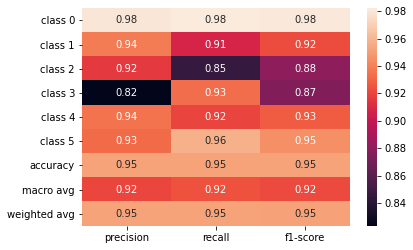

In [150]:
# Classification Report for HeatMap generation

target_names = ['class 0', 'class 1', 'class 2', 'class 3', 'class 4', 'class 5']
report = classification_report(y_true, y_pred, target_names=target_names, output_dict=True)
# .iloc[:-1, :] to exclude support
sns.heatmap(pd.DataFrame(report).iloc[:-1, :].T, annot=True)

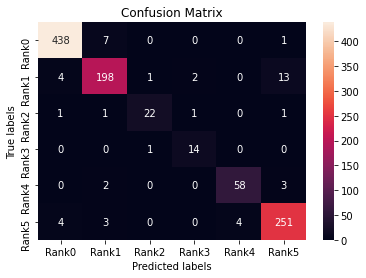

In [137]:
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax);
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Rank0', 'Rank1','Rank2','Rank3','Rank4','Rank5']); ax.yaxis.set_ticklabels(['Rank0', 'Rank1','Rank2','Rank3','Rank4','Rank5']);